In [1]:
import json

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import webcolors

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eglek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\eglek\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
with open('data.txt', encoding="utf8") as f:
    json_data = json.load(f)

In [9]:
for all_in_results in range(len(json_data['data']['results'])):
    print("title: " + json_data['data']['results'][all_in_results]['title'])
    for i in range(len(json_data['data']['results'][all_in_results]['tags'])):
        print(json_data['data']['results'][all_in_results]['tags'][i]['name'])

title: Domain Driven Design Made Easy
Domain driven design
Domain mapping
Domian objects
Domain abstraction
Hexagonal architecture
title: Kubernetes in Practice
Kubernetes
Container management
Kubernetes cluster
Multi container pods
Configmaps
title: Distributed Systems for Practitioners
Distributed systems
Large scale systems
Partitioning
Isolation
Atomicity
title: Burp Suite Extension Development
Burp
Penetration Testing
Security
Application Security
Burp Extender
title: Django Takeoff: Developing Modern Applications
Django setup
Bootstrap
Amazon Web Services
Heroku
title: Master State Management in Flutter
Flutter
Provider
Widgets
State management
title: The All-in-One Guide to Java Programming
Java 8
latest Java
Groovy
Scala
Java 7
title: Build a Successful Developer Brand
Developer interview
Marketing yourself
Resume design
Applying for jobs
title: Create Desktop Apps Using Python & Tkinter
python
tkinter
gui
Widgets
Geometry management
title: Learning Python through PowerShell Co

## Extract tags and do clustering

In [15]:
tags_list = []
for all_in_results in range(len(json_data['data']['results'])):
    for i in range(len(json_data['data']['results'][all_in_results]['tags'])):
        tags = json_data['data']['results'][all_in_results]['tags'][i]['name']
        tags_list.append(tags)

In [16]:
len(tags_list)

2401

In [17]:
tags_list_no_dub = list(set(tags_list)) 

In [18]:
len(tags_list_no_dub)

1522

In [20]:
df = pd.DataFrame(tags_list_no_dub, columns =['Tags'])
df

,Tags
0,FastAPI
1,Web
2,Pythonic way
3,OOP in JavaScript
4,Vue directives
...,...
1517,Quantum gates
1518,Git repository
1519,Elixir agents
1520,Frontend


In [21]:
#Remove stopwords, punctuation and numbers
df2 = [remove_stopwords(x)\
        .translate(str.maketrans('','',string.punctuation))\
        .translate(str.maketrans('','',string.digits))\
        for x in df['Tags']]

In [23]:
#Stem and make lower case
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words = word_tokenize(sentence)
    stem_sentence = [porter.stem(word) for word in token_words]
    return ' '.join(stem_sentence)

df3 = pd.Series([stemSentence(x) for x in df2])

In [24]:
df3

0              fastapi
1                  web
2           python way
3       oop javascript
4           vue direct
             ...      
1517      quantum gate
1518    git repositori
1519      elixir agent
1520          frontend
1521              lstm
Length: 1522, dtype: object

In [25]:
#Bag of words
vectorizer_cv = CountVectorizer(analyzer='word')
X_cv = vectorizer_cv.fit_transform(df3)

In [26]:
#TF-IDF (word level)
vectorizer_wtf = TfidfVectorizer(analyzer='word')
X_wtf = vectorizer_wtf.fit_transform(df3)

C:\Users\eglek\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


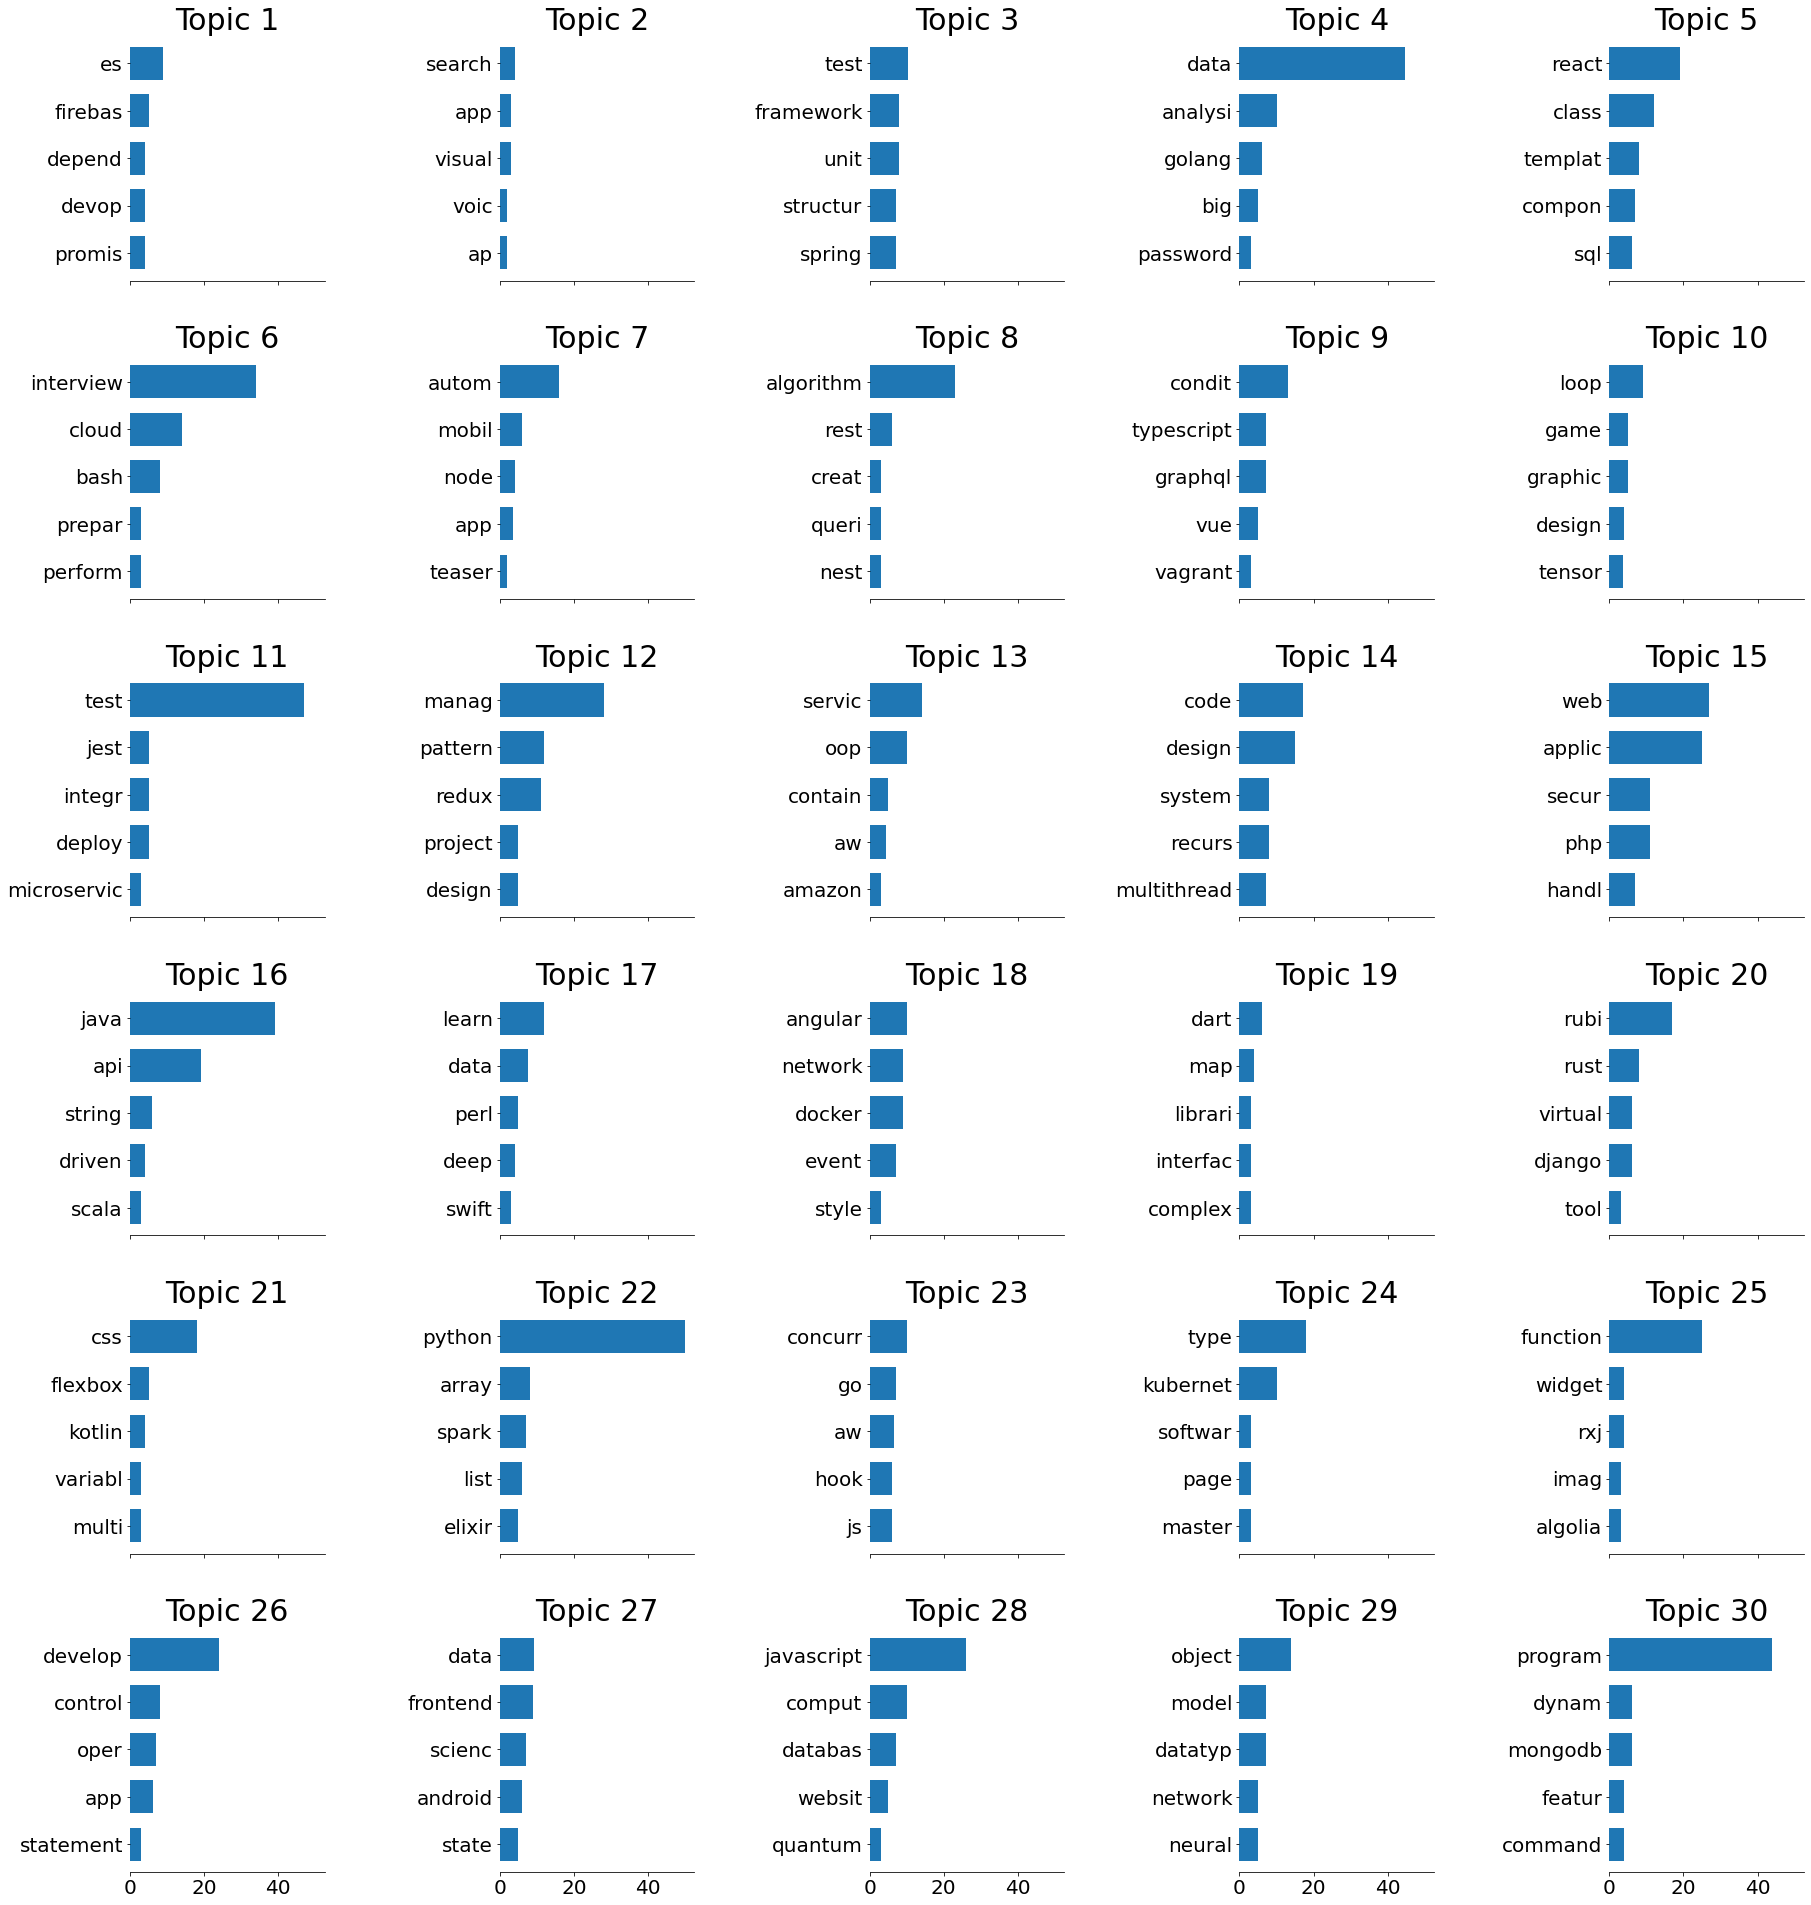

In [27]:
#LDA
lda = LatentDirichletAllocation(n_components=30, learning_decay=0.9)
X_lda = lda.fit(X_cv)

#Plot topics function. Code from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
#Show topics
n_top_words = 5
feature_names = vectorizer_cv.get_feature_names()
plot_top_words(X_lda, feature_names, n_top_words, '')

In [28]:
#Fuzzywuzzy
X_fuzz = pd.crosstab([df3.index,df3],df3).apply(lambda col: [fuzz.token_sort_ratio(col.name, x) 
                                                                   for x in col.index.get_level_values(1)])

In [29]:
X_fuzz

,col_0,aaa approach,access network,access token,action listen,actixweb,ad typescript,adonisj,advanc c,advanc placement ap,advanc python,...,write pseudocod,x xss protect,xml path,xpath,xsrf,xss,yaml,yarn,z score,zen python
row_0,row_1,,,,,,,,,,,,,,,,,,,,,
0,fastapi,32,29,32,30,40,40,29,27,23,30,...,18,10,13,17,18,20,18,18,14,12
1,web,0,12,13,12,55,12,0,0,9,0,...,11,12,0,0,0,0,0,0,20,15
2,python way,9,8,9,35,11,17,24,11,7,52,...,32,26,44,40,0,0,29,29,24,70
3,oop javascript,31,29,31,30,27,52,19,45,36,44,...,34,22,27,21,22,12,11,22,29,25
4,vue direct,9,17,18,35,33,26,24,22,21,17,...,24,43,22,13,14,0,0,14,35,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517,quantum gate,17,38,33,32,30,24,21,30,26,32,...,15,24,40,24,0,0,25,25,21,18
1518,git repositori,23,36,31,30,18,30,19,9,18,30,...,34,22,18,21,22,12,0,11,29,25
1519,elixir agent,25,38,25,40,40,32,32,30,26,24,...,22,32,40,12,25,13,25,25,11,18


# KMeans

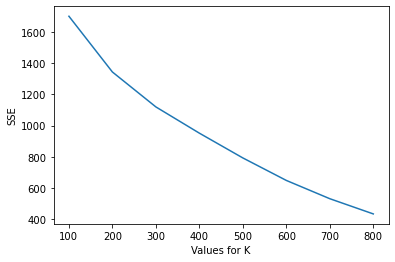

In [30]:
#Test increments of 100 clusters using elbow method
sse={}
for k in np.arange(100,900,100):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_cv)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();

In [31]:
#Create 200 clusters
kmeans = KMeans(n_clusters=200)
kmeans.fit(X_cv)
result = pd.concat([df['Tags'],pd.DataFrame(X_cv.toarray(),columns=vectorizer_cv.get_feature_names())],axis=1)
result['cluster'] = kmeans.predict(X_cv)

C:\Users\eglek\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
result[['Tags','cluster']]

,Tags,cluster
0,FastAPI,171
1,Web,12
2,Pythonic way,55
3,OOP in JavaScript,6
4,Vue directives,93
...,...,...
1517,Quantum gates,126
1518,Git repository,120
1519,Elixir agents,57
1520,Frontend,51


In [33]:
#Label each cluster with the word(s) that all of its food names have in common
clusters = result['cluster'].unique()
labels = []
for i in range(len(clusters)):
    subset = result[result['cluster'] == clusters[i]]
    words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='Tags' and x!='cluster' and len(x.split()) == 1])
    labels.append(words)
labels_table = pd.DataFrame(zip(clusters,labels),columns=['cluster','label'])
result_labelled = pd.merge(result,labels_table,on='cluster',how='left')

In [34]:
result_labelled

,Tags,aaa,abstract,access,account,action,activ,actixweb,actuat,ad,...,wrangl,write,xml,xpath,xsrf,xss,yaml,yarn,zen,label_y
0,FastAPI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,
1,Web,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,web
2,Pythonic way,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,python
3,OOP in JavaScript,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,oop
4,Vue directives,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,vue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1517,Quantum gates,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,quantum
1518,Git repository,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,git
1519,Elixir agents,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,elixir
1520,Frontend,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,frontend


In [35]:
result_labelled[['Tags','cluster','label_y']]

,Tags,cluster,label_y
0,FastAPI,171,
1,Web,12,web
2,Pythonic way,55,python
3,OOP in JavaScript,6,oop
4,Vue directives,93,vue
...,...,...,...
1517,Quantum gates,126,quantum
1518,Git repository,120,git
1519,Elixir agents,57,elixir
1520,Frontend,51,frontend


C:\Users\eglek\anaconda3\lib\site-packages\plotly\express\_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



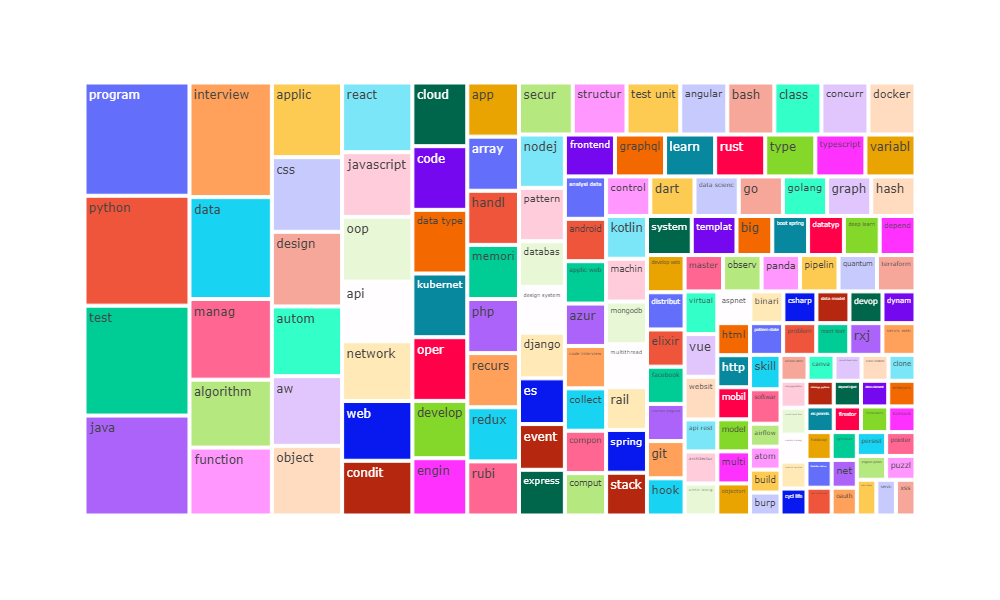

In [43]:
#Visualise sizes of supermarket categories (manually added to result_labelled) and clean clusters
result_summary = pd.pivot_table(result_labelled,index=['label_y'],values=['Tags'],aggfunc='count').reset_index().rename(columns={'Tags':'count'})
result_treemap = result_summary[(result_summary['label_y'] != '') & (result_summary['count'] > 1)]
fig = px.treemap(result_treemap,path=['label_y'],values='count',  width=1000, height=600)
fig.show("png");